[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/064_vit/vit.ipynb)

# *Visual Transformers*

En posts anteriores hemos aprendido e implementado la arquitectura *Transformer*, en particular el *Transformer Encoder* usado en multitud de aplicaciones. Una de ellas, es la tarea de clasificación de imágenes. Y un ejemplo de implementación lo encontramos en el artículo [ViT](https://arxiv.org/abs/2010.11929).

![](vit.png)

En este post vamos a implementar esta arquitectura y aplicarla en varios ejemplos.

## Dataset

Empezamos descargando y preparando el dataset MNIST. De forma similar a lo que vimos en el post anterior, ViT espera una lista de *patches*. 

In [1]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader

In [20]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X 
    self.y = y 

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float().view(1, 28, 28), torch.tensor(self.y[ix]).long()

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        mnist = fetch_openml('mnist_784', version=1)
        X, y = mnist["data"], mnist["target"]
        X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(np.int), y[60000:].astype(np.int)
        self.train_ds = Dataset(X_train, y_train)
        self.val_ds = Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [21]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

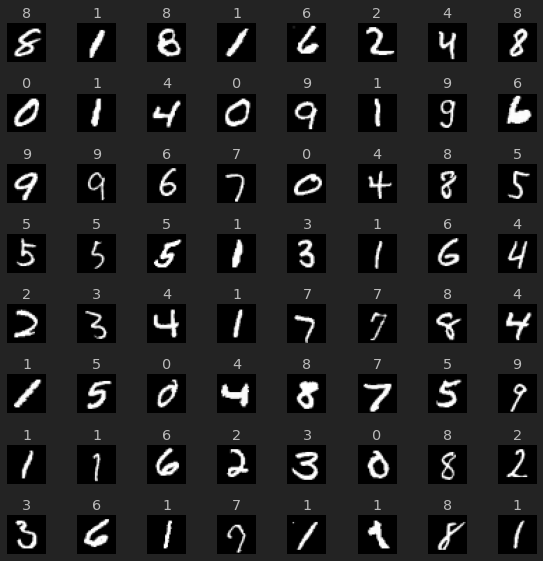

In [22]:
r, c = 8, 8
fig = plt.figure(figsize=(c, r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.squeeze(0), cmap="gray")
        ax.set_title(label.item())
plt.tight_layout()
plt.show()

## El modelo

Empezamos con la implementación del *patch embedding*. Este módulo recibirá un batch de imágenes y se encargará de proyectar los diferentes *patches*. Para ello podemos usar una capa convolucional.

In [31]:
import torch.nn as nn

# https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

In [32]:
pe = PatchEmbedding(28, 7, 1, 100)
out = pe(imgs)
out.shape

torch.Size([64, 16, 100])

Una vez tenemos nuestros datos proyectados, podemos dárselos a nuestro transformer encoder para que haga su magia.

In [33]:
import math

class MultiHeadAttention(nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads 
        
        # key, query, value projections
        self.key = nn.Linear(n_embd, n_embd*n_heads)
        self.query = nn.Linear(n_embd, n_embd*n_heads)
        self.value = nn.Linear(n_embd, n_embd*n_heads)
        
        # output projection
        self.proj = nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        
        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L) 
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side
        
        return self.proj(y)

In [34]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )
        
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

Siguiendo el trabajo de los autores originales, ya solo nos faltaría añadir el token `class` y los *postitional embeddings*.

In [37]:
class ViT(nn.Module):

    def __init__(self, img_size=28, patch_size=7, in_chans=1, embed_dim=100, n_heads=3, n_layers=3, n_classes=10):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        
        self.tranformer = torch.nn.Sequential(*[TransformerBlock(embed_dim, n_heads) for _ in range(n_layers)])
        
        self.ln = nn.LayerNorm(embed_dim)
        self.fc = torch.nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        e = self.patch_embed(x)
        B, L, E = e.size()
        
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
        e = torch.cat((cls_token, e), dim=1)  # (B, 1 + N, E)
        e = e + self.pos_embed  # (B, 1 + N, E)
        
        z = self.tranformer(e)
        
        cls_token_final = z[:, 0]  
        y = self.fc(cls_token_final)

        return y

In [38]:
vit = ViT()
out = vit(imgs)
out.shape

torch.Size([64, 10])

In [39]:
class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.vit = ViT()

    def forward(self, x):
        return self.vit(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
        return optimizer

In [40]:
model = Model()
out = model(imgs)
out.shape

torch.Size([64, 10])

In [42]:
model = Model()
trainer = pl.Trainer(max_epochs=5, gpus=1)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vit  | ViT  | 613 K 


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Obtenemos una precisión en los datos de validación del 97%, nada impresionante debido a la simplicidad del modelo.

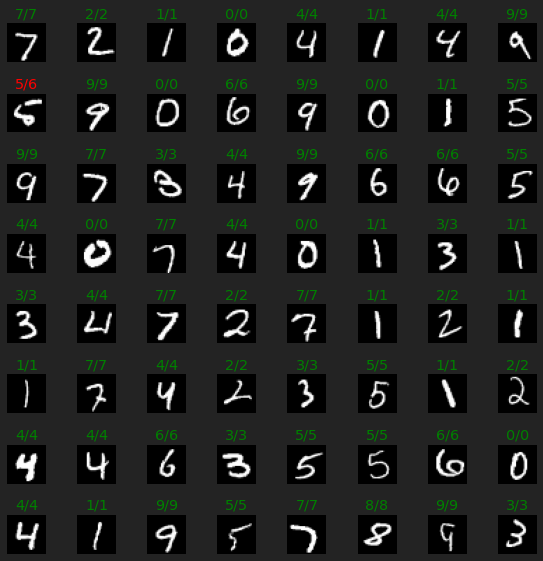

In [43]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = model.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(c, r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

Usando otra implementación

In [57]:
from timm.models.vision_transformer import VisionTransformer

# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

class Model2(Model):
    def __init__(self):
        super().__init__()
        self.vit = VisionTransformer(
            img_size=28, 
            patch_size=7, 
            in_chans=1, 
            num_classes=10, 
            embed_dim=100, 
            depth=3, 
            num_heads=2
        )

In [58]:
model2 = Model2()
out = model2(imgs)
out.shape

torch.Size([64, 10])

In [64]:
dm2 = MNISTDataModule(batch_size=2048)

In [65]:
model2 = Model2()
trainer = pl.Trainer(max_epochs=15, gpus=1, precision=16)
trainer.fit(model2, dm2)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name | Type              | Params
-------------------------------------------
0 | vit  | VisionTransformer | 371 K 


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

## Resumen

Hemos visto como mejorar el mecanismo de atención añadiendo varias cabezas a las cuales atender en paralelo. De esta forma, la capacidad para representar datos de nuestro modelo se ve incrementada. 